In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from data_for_gan import data_for_gan
from tqdm import tqdm

In [83]:
dataset,y,df = data_for_gan(frames = 20)

[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0]


In [84]:
dataset = np.transpose(dataset, (0, 2, 1, 3))

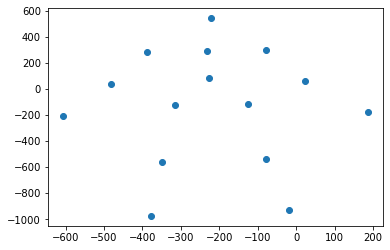

In [85]:
plt.scatter(dataset[0][0][:,0], dataset[0][0][:,1])

In [86]:
max_x = np.max(dataset[: , : , :, 0])
min_x = np.min(dataset[: , : , :, 0])
dataset[: , : , :, 0] = (dataset[: , : , :, 0] - min_x)/(max_x - min_x)

In [87]:
max_y = np.max(dataset[: , : , :, 1])
min_y = np.min(dataset[: , : , :, 1])
dataset[: , : , :, 1] = (dataset[: , : , :, 1] - min_y)/(max_y - min_y)

In [88]:
max_z = np.max(dataset[: , : , :, 2])
min_z = np.min(dataset[: , : , :, 2])
dataset[: , : , :, 2] = (dataset[: , : , :, 2] - min_z)/(max_z - min_z)

In [89]:
dataset = dataset - 0.5

In [90]:
dataset = np.transpose(dataset, (0,3,1,2))

In [91]:
dataset = torch.from_numpy(dataset.astype('float32'))
y = torch.from_numpy(y.astype('int32'))

In [92]:
dataset.size()

torch.Size([215, 3, 20, 15])

In [93]:
class CustomDataset(Dataset):
    def __init__(self,imgs,labels):
        self.imgs = imgs
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [94]:
dataset = CustomDataset(dataset, y)

In [95]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=43,
    shuffle=True,
)

In [96]:
img_shape = np.array([3,20,15])

In [97]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(9, 20)
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        labels = self.embed(labels)
        # print(labels.size())
        # print(z.size())
        z = torch.concat([z,labels], dim = 1)
        # print(z.size())
        img = self.model(z)
        # print(img.size())
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(9, 50)
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + 50, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        labels = self.embed(labels)
        # print(img.size())
        labels = labels.view(labels.size(0), -1)
        # print(labels.size())
        img_flat = img.reshape(img.size(0), -1)
        # print(img_flat.size())
        img_flat = torch.concat([img_flat, labels], dim = -1)
        # print(img_flat.size())
        validity = self.model(img_flat)
        return validity

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [99]:
device

device(type='cuda')

In [124]:
'''
Models
'''
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [125]:
'''
Losses
'''
# adversarial_loss = nn.BCELoss()
# adversarial_loss = adversarial_loss.cuda()

'\nLosses\n'

In [126]:
'''
Optimizers
'''
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.00005)

In [127]:
cuda = torch.cuda.is_available()

In [128]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

epochs = 20000

In [129]:
batches_done = 0
for epoch in range(epochs):

    for i, (imgs, labels) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------
        labels = labels.to(device)
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 80))))

        # Generate a batch of images
        fake_imgs = generator(z,labels).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs,labels)) + torch.mean(discriminator(fake_imgs,labels))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Train the generator every n_critic iterations
        if i+1 % 1 == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z,labels)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs,labels))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )
            batches_done += 5


[Epoch 0/20000] [Batch 0/5] [D loss: 0.005914] [G loss: -0.011162]
[Epoch 1/20000] [Batch 0/5] [D loss: -0.015756] [G loss: -0.011391]
[Epoch 2/20000] [Batch 0/5] [D loss: -0.045622] [G loss: -0.012546]
[Epoch 3/20000] [Batch 0/5] [D loss: -0.092963] [G loss: -0.017447]
[Epoch 4/20000] [Batch 0/5] [D loss: -0.139193] [G loss: -0.031248]
[Epoch 5/20000] [Batch 0/5] [D loss: -0.177812] [G loss: -0.053809]
[Epoch 6/20000] [Batch 0/5] [D loss: -0.230891] [G loss: -0.080656]
[Epoch 7/20000] [Batch 0/5] [D loss: -0.245974] [G loss: -0.115269]
[Epoch 8/20000] [Batch 0/5] [D loss: -0.273447] [G loss: -0.151608]
[Epoch 9/20000] [Batch 0/5] [D loss: -0.281390] [G loss: -0.194883]
[Epoch 10/20000] [Batch 0/5] [D loss: -0.300036] [G loss: -0.244576]
[Epoch 11/20000] [Batch 0/5] [D loss: -0.300114] [G loss: -0.286825]
[Epoch 12/20000] [Batch 0/5] [D loss: -0.327056] [G loss: -0.329881]
[Epoch 13/20000] [Batch 0/5] [D loss: -0.282308] [G loss: -0.384875]
[Epoch 14/20000] [Batch 0/5] [D loss: -0.2506

In [119]:
images = generator(torch.randn(10, 80).to(device), dataset.labels[0:10].to('cuda')).to(device)

In [120]:
images.size()

torch.Size([10, 3, 20, 15])

In [121]:
images[:,0,:,:] = (images[:,0,:,:] * (max_x - min_x) ) + min_x
images[:,1,:,:] = (images[:,1,:,:] * (max_y - min_y) ) + min_y
images[:,2,:,:] = (images[:,2,:,:] * (max_z - min_z) ) + min_z